In [1]:
! pip install kaggle

In [2]:
!rm -rf /content/dataset

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download sriramr/fruits-fresh-and-rotten-for-classification

Dataset URL: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
License(s): unknown
100% 3.58G/3.58G [00:37<00:00, 34.2MB/s]
100% 3.58G/3.58G [00:37<00:00, 103MB/s] 


In [7]:
!python --version

Python 3.10.12


In [8]:
import torch
torch.__version__

'2.3.0+cu121'

In [9]:
! unzip fruits-fresh-and-rotten-for-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.09 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.18 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.24 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.37 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.51 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.02 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.12 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.21 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.31 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07

In [10]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

In [13]:

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freezing the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

class_names = ['freshapples','freshbanana','freshoranges','rottenapples','rottenbanana','rottenoranges']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 156MB/s]


In [14]:
!pip install torchinfo

In [15]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [16]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


**Data Augmentation**

In [17]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F
import random
import matplotlib.pyplot as plt

train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test'

NUM_WORKERS = os.cpu_count()

class CustomAugmentation:
    def __init__(self):
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        self.additive_gaussian_noise = transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.05)

    def __call__(self, image):
        # Random flip
        if random.random() > 0.5:
            image = F.hflip(image)

        # Random brightness and contrast adjustment
        image = transforms.ColorJitter(brightness=0.1, contrast=0.1)(image)

        # Random rotation
        if random.random() > 0.5:
            angle = random.choice([0, 90, 180, 270])
            image = F.rotate(image, angle)

        # Apply Gaussian blur
        if random.random() > 0.5:
            image = self.gaussian_blur(image)

        return image

class AddGaussianNoise:
    def __call__(self, image):
        return image + torch.randn_like(image) * 0.05

# Defining transform with custom augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images first
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure image is in RGB format
    CustomAugmentation(),           # Apply custom augmentations
    transforms.ToTensor(),          # Convert images to tensors
    AddGaussianNoise()              # Add Gaussian noise to tensors
])

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    # Using ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]))

    # class names
    class_names = train_data.classes

    # Turning images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names


In [18]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                          test_dir=test_dir,
                                                                                          transform=pretrained_vit_transforms,
                                                                                          batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [19]:
!unzip going_modular.zip

Archive:  going_modular.zip
   creating: going_modular/going_modular/
   creating: going_modular/going_modular/__pycache__/
  inflating: going_modular/going_modular/__pycache__/engine.cpython-39.pyc  
  inflating: going_modular/going_modular/__pycache__/predictions.cpython-39.pyc  
  inflating: going_modular/going_modular/engine.py  
  inflating: going_modular/going_modular/model_builder.py  
  inflating: going_modular/going_modular/predictions.py  
  inflating: going_modular/going_modular/train.py  
  inflating: going_modular/going_modular/utils.py  


In [20]:
import numpy as np
epoch=5
def lr_schedule(epoch):
    initial_lr = 1e-3
    k = 0.2  # Decay rate
    lr = initial_lr * np.exp(-k * epoch)
    print('Learning rate: ', lr)
    return lr

In [21]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=lr_schedule(epoch))
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=5,
                                      device=device)

Learning rate:  0.00036787944117144236


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3383 | train_acc: 0.9257 | test_loss: 0.3282 | test_acc: 0.9220
Epoch: 2 | train_loss: 0.0861 | train_acc: 0.9815 | test_loss: 0.2653 | test_acc: 0.9224
Epoch: 3 | train_loss: 0.0536 | train_acc: 0.9908 | test_loss: 0.2248 | test_acc: 0.9338
Epoch: 4 | train_loss: 0.0383 | train_acc: 0.9936 | test_loss: 0.2251 | test_acc: 0.9246
Epoch: 5 | train_loss: 0.0290 | train_acc: 0.9949 | test_loss: 0.1949 | test_acc: 0.9357


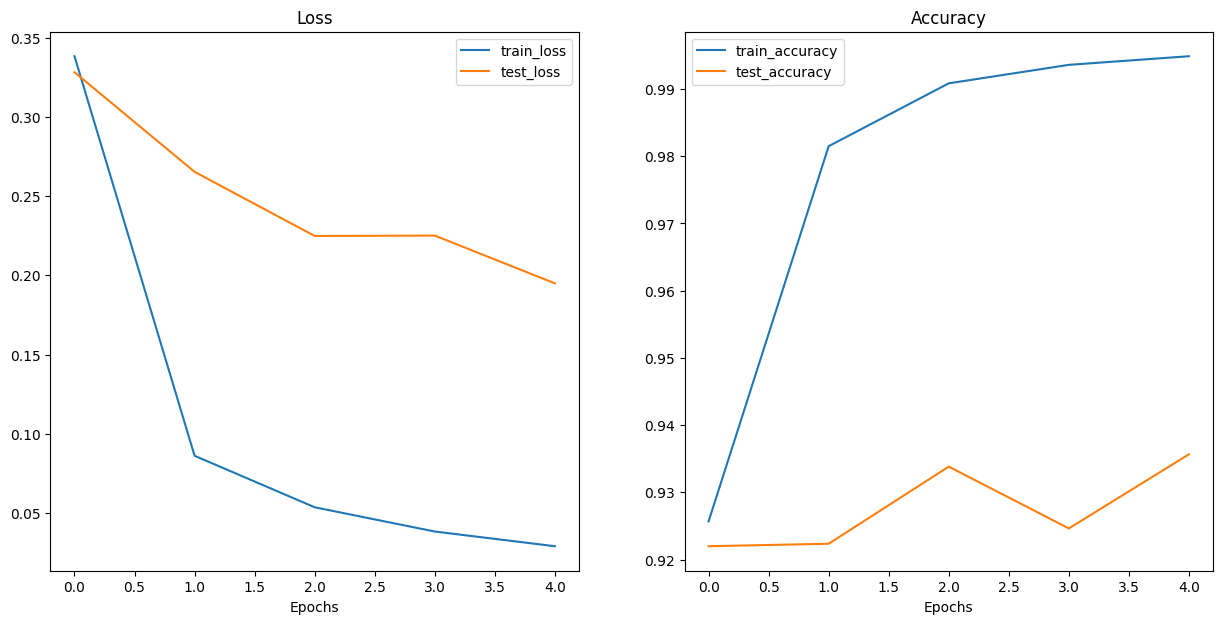

In [22]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)